In [2]:
import pandas as pd

In [3]:
url = "https://raw.githubusercontent.com/priyam-g/IPL_project/main/AAPL.csv"
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index

DatetimeIndex(['1980-12-12', '1980-12-15', '1980-12-16', '1980-12-17',
               '1980-12-18', '1980-12-19', '1980-12-22', '1980-12-23',
               '1980-12-24', '1980-12-26',
               ...
               '2022-03-11', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22',
               '2022-03-23', '2022-03-24'],
              dtype='datetime64[ns]', name='Date', length=10409, freq=None)

In [5]:
numeric_columns = df.select_dtypes(include=['object']).columns

df[numeric_columns] = df[numeric_columns].astype(float)

print(df.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


<Axes: xlabel='Date'>

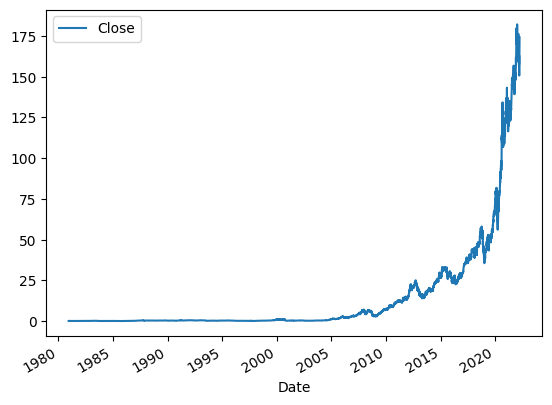

In [6]:
df.plot.line (y="Close", use_index=True)

In [7]:
df=df.loc["1990-01-01":].copy()
df['Tomorrow']=df['Close'].shift(-1)
df['Target']=(df['Tomorrow']>df['Close']).astype(int)
df

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.266078,183198400,0.334821,1
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.267863,207995200,0.335938,1
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.268757,221513600,0.337054,1
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.269650,123312000,0.339286,1
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.271435,101572800,0.335938,0
...,...,...,...,...,...,...,...,...
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,165.380005,1
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,168.820007,1
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,170.210007,1


In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
train=df.iloc[:-300]
test=df.iloc [-300:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train [predictors], train["Target"])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [9]:
from sklearn.metrics import precision_score
preds=model.predict(test[predictors])
preds=pd.Series(preds,index=test.index)
precision_score(test['Target'],preds)

0.4375

In [10]:
def predict(train, test, predictors, model):
  model.fit(train [predictors], train ["Target"])
  preds = model.predict(test [predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [11]:
def backtest (data, model, predictors, start=2500, step=250):
  all_predictions =[]
  for i in range (start, data.shape [0], step):
    train = data.iloc [0: i].copy()
    test = data.iloc [i: (i+step)]. copy()
    predictions = predict(train, test, predictors, model)
    all_predictions .append(predictions)
  return pd.concat(all_predictions)

In [12]:
predictions = backtest (df, model, predictors)
precision_score(predictions ["Target"], predictions ["Predictions"])

0.5184275184275184

In [13]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.520904
0    0.479096
Name: Target, dtype: float64

In [14]:
df['Day'] = df.index.day
df['Month'] = df.index.month
predictors = ["Close", "Volume", "Open", "High", "Low","Day","Month"]
predictions = backtest (df, model, predictors)
precision_score(predictions ["Target"], predictions ["Predictions"])

0.5324751316559392

In [15]:
import pandas as pd

def calculate_rsi(prices, window=14):
    # Calculate price changes
    price_diff = prices.diff(1)

    # Get positive and negative price changes
    positive_diff = price_diff.where(price_diff > 0, 0)
    negative_diff = -price_diff.where(price_diff < 0, 0)

    # Calculate average gain and average loss
    average_gain = positive_diff.rolling(window).mean()
    average_loss = negative_diff.rolling(window).mean()

    # Calculate relative strength (RS) and relative strength index (RSI)
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI'] = calculate_rsi(df['Close'])
df

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Day,Month,RSI
Date,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.266078,183198400,0.334821,1,2,1,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.267863,207995200,0.335938,1,3,1,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.268757,221513600,0.337054,1,4,1,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.269650,123312000,0.339286,1,5,1,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.271435,101572800,0.335938,0,8,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,165.380005,1,18,3,48.750001
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,168.820007,1,21,3,52.417932
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,170.210007,1,22,3,52.502224


In [16]:
import pandas as pd
import numpy as np

def calculate_atr(df, n=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = np.abs(high - close.shift())
    tr3 = np.abs(low - close.shift())
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Calculate Average True Range (ATR)
    atr = true_range.rolling(window=n).mean()

    return atr

def calculate_bollinger_bands(df, n=20, k=2):
    close = df['Close']

    # Calculate Simple Moving Average (SMA)
    sma = close.rolling(window=n).mean()

    # Calculate Standard Deviation
    std = close.rolling(window=n).std()

    # Calculate Bollinger Bands
    upper_band = sma + k * std
    lower_band = sma - k * std

    return upper_band, lower_band

# Assuming you have a DataFrame named 'df' with columns: 'High', 'Low', 'Close'

# Calculate ATR
df['ATR'] = calculate_atr(df)

# Calculate Bollinger Bands
df['UpperBand'], df['LowerBand'] = calculate_bollinger_bands(df)

# Print the updated DataFrame
df

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Day,Month,RSI,ATR,UpperBand,LowerBand
Date,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.266078,183198400,0.334821,1,2,1,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.267863,207995200,0.335938,1,3,1,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.268757,221513600,0.337054,1,4,1,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.269650,123312000,0.339286,1,5,1,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.271435,101572800,0.335938,0,8,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,165.380005,1,18,3,48.750001,5.054285,170.153955,152.486044
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,168.820007,1,21,3,52.417932,4.962143,169.822935,152.625064
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,170.210007,1,22,3,52.502224,4.969285,170.606391,152.291609


In [17]:
# Define the specific time period for calculating the average volume
window = 14

# Calculate the average volume over the specific time period
average_volume = df['Volume'].rolling(window).mean()

# Calculate the Volume Ratio
volume_ratio = df['Volume'] / average_volume

# Add the Volume Ratio as a new column in the dataframe
df['Volume_Ratio'] = volume_ratio

In [18]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])

In [19]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [20]:
predictions = backtest(df, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.55741127348643

In [21]:
new_predictors+=['RSI']
predictions = backtest(df, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])
# f1_score(predictions["Target"], predictions["Predictions"])

0.5717299578059072

In [22]:
new_predictors+=['ATR']
predictions = backtest(df, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.5366568914956011

In [23]:
new_predictors+=['Volume_Ratio']
predictions = backtest(df, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.5551724137931034

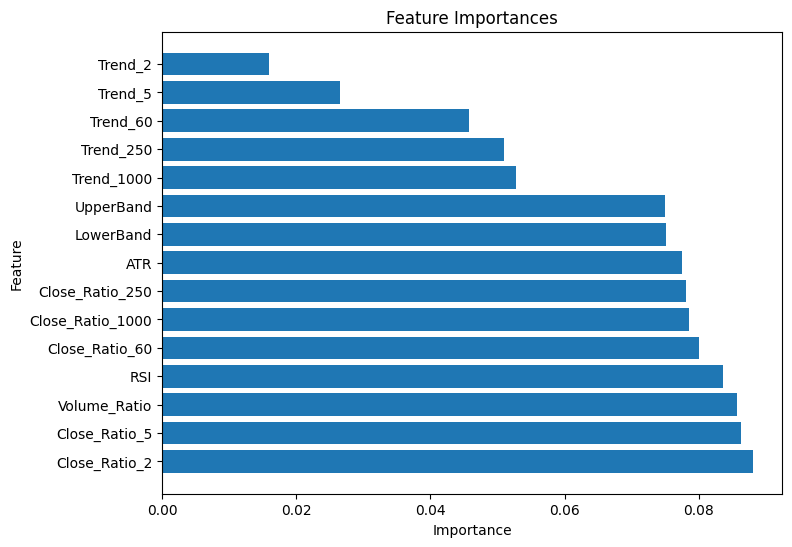

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
new_predictors+=['UpperBand','LowerBand']
# Assuming your features are stored in columns 1-5 and the target variable is in column 'Target'
X = df[new_predictors]  # Features
y = df['Target']      # Target variable

# Create a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X, y)

# Get feature importances
importance_scores = clf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': new_predictors, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


Correlation Matrix:
                  Close_Ratio_2   Trend_2  Close_Ratio_5   Trend_5  \
Close_Ratio_2          1.000000  0.467074       0.722680  0.301959   
Trend_2                0.467074  1.000000       0.586463  0.629904   
Close_Ratio_5          0.722680  0.586463       1.000000  0.530274   
Trend_5                0.301959  0.629904       0.530274  1.000000   
Close_Ratio_60         0.224665  0.239280       0.405280  0.366618   
Trend_60               0.081837  0.199754       0.148754  0.318231   
Close_Ratio_250        0.111212  0.158245       0.202757  0.248874   
Trend_250              0.037192  0.122720       0.065273  0.193137   
Close_Ratio_1000       0.056057  0.103590       0.102068  0.164320   
Trend_1000             0.012332  0.072021       0.020164  0.114190   
RSI                    0.234974  0.321191       0.424473  0.495945   
ATR                   -0.002644  0.007403      -0.009293  0.005670   
Volume_Ratio           0.040302  0.029764       0.057675  0.019612   


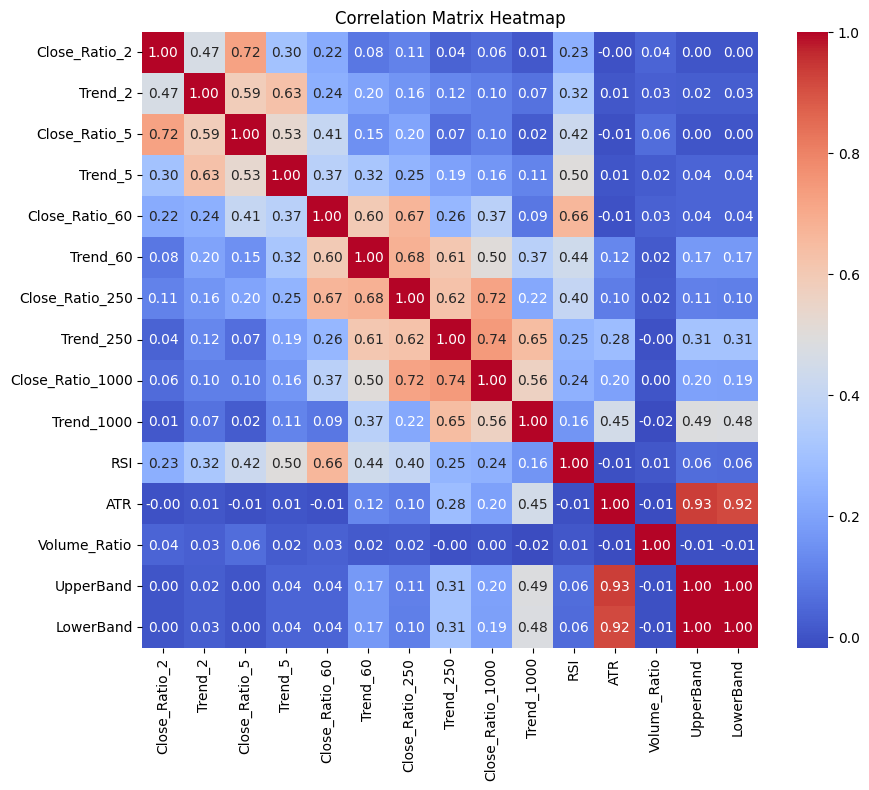


Variance Inflation Factor (VIF):
             Feature          VIF
0      Close_Ratio_2  3957.224450
1            Trend_2     5.668050
2      Close_Ratio_5  3572.143902
3            Trend_5    13.558380
4     Close_Ratio_60   260.682356
5           Trend_60   131.772465
6    Close_Ratio_250    94.933109
7          Trend_250   463.241963
8   Close_Ratio_1000    20.754676
9         Trend_1000   711.565185
10               RSI    23.957543
11               ATR    19.232801
12      Volume_Ratio     5.649065
13         UpperBand   759.166258
14         LowerBand   600.163921


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming your features are stored in columns 1-5 of the dataframe 'df'
X = df[new_predictors]  # Features

# Calculate the correlation matrix
correlation_matrix = X.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Calculate the Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)



In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score

# new_predictors = [value for value in new_predictors if value not in ['Volume_Ratio', 'ATR']]

# Assuming you have a DataFrame called 'df' with features and a target variable
X = df[new_predictors]  # Features
y = df['Target']   # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC()

# Perform cross-validation
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='precision')

# Train the SVM classifier on the entire training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the precision of the SVM classifier
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())


Precision: 0.5328310010764262
Cross-Validation Scores: [0.51383399 0.52015605 0.51165803 0.51387054 0.53625   ]
Mean Cross-Validation Score: 0.5191537223217227


In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score

new_predictors = [value for value in new_predictors if value not in ['Volume_Ratio', 'ATR']]

# Assuming you have a DataFrame called 'df' with features and a target variable
X = df[new_predictors]  # Features
y = df['Target']   # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC()

# Perform cross-validation
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='precision')

# Train the SVM classifier on the entire training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the precision of the SVM classifier
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())


Precision: 0.5315508021390374
Cross-Validation Scores: [0.51383399 0.52077922 0.51102464 0.51387054 0.53566959]
Mean Cross-Validation Score: 0.51903559695796


In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.datasets import make_classification

X = df[new_predictors]
y = df['Target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding precision score
best_params = grid_search.best_params_
best_precision = grid_search.best_score_

# Train the SVM classifier with the best hyperparameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm.predict(X_test)

# Evaluate the precision of the SVM classifier
precision = precision_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Best Precision:", best_precision)
print("Test Set Precision:", precision)


Best Hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Precision: 0.542852052151219
Test Set Precision: 0.543859649122807


In [29]:
pip install xgboost

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

X = df[new_predictors]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42

)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

cv_results = xgb.cv(
    xgb_model.get_xgb_params(),
    xgb.DMatrix(X_train, label=y_train),
    num_boost_round=100,
    nfold=5,
    metrics='logloss',
    early_stopping_rounds=10,
    seed=42
)

best_logloss = cv_results['test-logloss-mean'].min()
print("Best Cross-Validation Log Loss:", best_logloss)


Precision: 0.5521796565389696
Recall: 0.5565912117177098
Best Cross-Validation Log Loss: 0.6940168708976768


In [31]:
df1=df.reset_index()['Close']
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [33]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(4527, 100)
(4527,)
(2392, 100)
(2392,)


(None, None)

In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
71/71 [==============================] - 26s 254ms/step - loss: 6.4884e-05 - val_loss: 0.0020
Epoch 2/100
71/71 [==============================] - 16s 221ms/step - loss: 3.2859e-06 - val_loss: 0.0012
Epoch 3/100
71/71 [==============================] - 16s 229ms/step - loss: 3.1760e-06 - val_loss: 7.8850e-04
Epoch 4/100
71/71 [==============================] - 28s 401ms/step - loss: 3.4317e-06 - val_loss: 6.3063e-04
Epoch 5/100
71/71 [==============================] - 20s 284ms/step - loss: 3.2554e-06 - val_loss: 6.1081e-04
Epoch 6/100
71/71 [==============================] - 16s 221ms/step - loss: 3.0458e-06 - val_loss: 4.7397e-04
Epoch 7/100
71/71 [==============================] - 16s 231ms/step - loss: 2.8327e-06 - val_loss: 4.9578e-04
Epoch 8/100
71/71 [==============================] - 16s 220ms/step - loss: 2.7021e-06 - val_loss: 5.2261e-04
Epoch 9/100
71/71 [==============================] - 16s 230ms/step - loss: 2.7663e-06 - val_loss: 3.6373e-04
Epoch 10/100
71/71

In [42]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

75/75 [==============================] - 3s 39ms/step


In [43]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

5.045467965748594

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

68.31450175267311

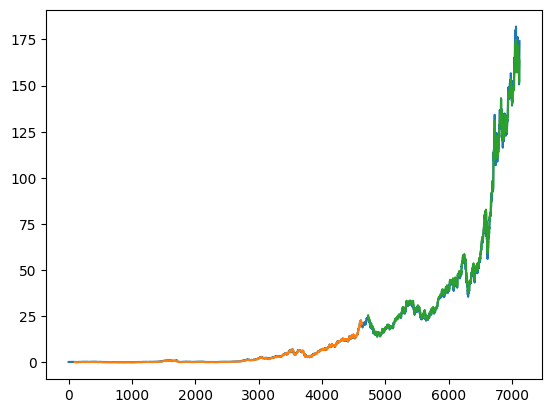

In [46]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()